In [3]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
import random
from tqdm import tqdm
import torch
from torch.autograd.functional import jvp
from defense import *
import inversefed
arch = 'ConvNet32'

torch.manual_seed(50)

batch_size = 8
idx = 30

print(torch.__version__, torchvision.__version__)

import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('MNIST', defs)
dst=validloader.dataset

# train_indices = list(range(idx, idx + batch_size))
# train_subset = Subset(dst, train_indices)
# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

# test_indices = list(range(len(dst)))
# test_subset = Subset(dst, test_indices)
# test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

train_indices = list(range(idx, idx + batch_size))
train_subset = Subset(dst, train_indices)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

test_indices = list(range(len(dst)))
test_subset = Subset(dst, test_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)


2.0.1+cu118 0.15.2+cu118
Currently evaluating -------------------------------:
Tuesday, 08. October 2024 09:49PM
CPUs: 14, GPUs: 1 on LAPTOP-HS456NH3.
GPU : NVIDIA GeForce RTX 2050
Running on cuda


In [44]:
class SimpleConvNet(nn.Module):
    def __init__(self, num_classes=10, num_channels=1):
        super(SimpleConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)  # 14x14 -> 7x7
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [21]:
batch_size = 64
split_batch=4
test_loader=train_loader
defense_method = lambda x,y,z,w: defense_dpsgd(x,y,z,w,clipping_threshold=1)
# defense_method=defense_prune
num_epoch = 3
lr = 1e-3
criterion = lambda x,y:loss_fn(x,y)[0]

for noise_scale in [1e-5]:
    for num_samples in [10]: #Num samples for random sketching
        for defense_type in ['ours']:
            train_indices = list(range(1,4097))
            train_subset = Subset(dst, train_indices)
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

            test_indices = list(range(5001,6025))
            test_subset = Subset(dst, test_indices)
            test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
            print(f'\n\n\n\n___^^^___noise_scale:{noise_scale}, defense_method:{defense_type}___^^^___')

            torch.manual_seed(0)
            net=SimpleConvNet()
            net.to(device)
            loss = []
            acc = []
            norms = []
            defense = True
            optimizer = optim.Adam(net.parameters(), lr=lr)
            for _ in range(num_epoch):
                print(f'______EPOCH {_+1}_______')
                t=tqdm(train_loader)
                for gt_data, gt_label in t:
                    gt_data, gt_label = gt_data.to(device), gt_label.to(device)
                    gt_onehot_label = label_to_onehot(gt_label, num_classes=10)

                    optimizer.zero_grad()

                    split_size = batch_size // split_batch
                    parts_data = torch.split(gt_data, split_size)
                    parts_label = torch.split(gt_label, split_size)
                    parts_onehot_label = torch.split(gt_onehot_label, split_size)

                    accumulated_gradients = None

                    for part_data, part_label, part_onehot_label in zip(parts_data, parts_label, parts_onehot_label):
                        part_data.requires_grad_(True)
                        out = net(part_data)
                        y = criterion(out, part_label)
                        original_dy_dx = torch.autograd.grad(y, net.parameters(), create_graph=True)
                        l2_norms_dy_dx=None

                        if defense:
                            if defense_type != 'default':
                                l2_norms_dy_dx = compute_l2_norm_of_gradients_new(net, part_data, part_onehot_label, criterion, num_samples=num_samples)
                            modified_dy_dx = defense_method(original_dy_dx, l2_norms_dy_dx, noise_scale, defense_type)
                        else:
                            modified_dy_dx = original_dy_dx

                        if accumulated_gradients is None:
                            accumulated_gradients = [grad.clone() for grad in modified_dy_dx]
                        else:
                            for i in range(len(accumulated_gradients)):
                                accumulated_gradients[i] += modified_dy_dx[i]

                    for i in range(len(accumulated_gradients)):
                        accumulated_gradients[i] /= split_batch

                    with torch.no_grad():
                        for param, grad in zip(net.parameters(), accumulated_gradients):
                            param.grad = grad
                    optimizer.step()

                    loss.append(y.item())
                    acc.append((torch.argmax(net(gt_data), dim=1) == gt_label).float().mean().item())
                    if defense and defense_type=='ours':
                        normalizer=[(torch.clamp(torch.abs(l2_norms_dy_dx[i]/torch.clamp(original_dy_dx[i],min=1e-6)),min=1e-6,max=1e6))**0.5 for i in range(len(original_dy_dx))]
                        s=mean_of_square_tensors(normalizer)**0.5
                        norms.append([torch.mean(i/s).item() for i in normalizer])
                    t.set_description(f"Loss: {loss[-1]}, Acc: {acc[-1]}")

            epoch_test_loss = 0
            epoch_test_acc = 0
            with torch.no_grad():
                for test_data, test_label in test_loader:
                    test_data, test_label = test_data.to(device), test_label.to(device)
                    test_out = net(test_data)
                    test_y = criterion(test_out, test_label)
                    epoch_test_loss += test_y.item()
                    epoch_test_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

            final_test_loss=epoch_test_loss / len(test_loader)
            final_test_acc=epoch_test_acc / len(test_loader)
            print(f"Final Test Loss: {final_test_loss}, Final Test Acc: {final_test_acc}")

            epoch_train_loss = 0
            epoch_train_acc = 0
            with torch.no_grad():
                for test_data, test_label in train_loader:
                    test_data, test_label = test_data.to(device), test_label.to(device)
                    test_out = net(test_data)
                    test_y = criterion(test_out, test_label)
                    epoch_train_loss += test_y.item()
                    epoch_train_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

            final_train_loss=epoch_train_loss / len(train_loader)
            final_train_acc=epoch_train_acc / len(train_loader)
            print(f"Final Train Loss: {final_train_loss}, Final Train Acc: {final_train_acc}")
            
            with open('data_train_detail.txt', 'a') as file:
                file.write(f"k: {noise_scale}, Defense type: {defense_type}\nLoss: {loss}\nAcc: {acc}\n\n")

            with open('data_train.txt', 'a') as file:
                file.write(f"Final train loss: {final_train_loss}, Final test loss: {final_test_loss}, Final train acc: {final_train_acc}, Final test acc: {final_test_acc}, k: {noise_scale}, Defense type: {defense_type}, Num_Samples: {num_samples}\n")





___^^^___noise_scale:1e-05, defense_method:ours___^^^___
______EPOCH 1_______


  0%|          | 0/64 [00:00<?, ?it/s]

Loss: 0.1067417785525322, Acc: 0.921875: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s] 


______EPOCH 2_______


Loss: 0.036361854523420334, Acc: 0.9375: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s] 


______EPOCH 3_______


Loss: 0.01689537987112999, Acc: 0.96875: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s]  


Final Test Loss: 0.14326067065121606, Final Test Acc: 0.9619140625
Final Train Loss: 0.09725580431404524, Final Train Acc: 0.96875


conv_layers.0.weight 288
conv_layers.0.bias 32
conv_layers.3.weight 18432
conv_layers.3.bias 64
fc_layers.1.weight 100352
fc_layers.1.bias 32
fc_layers.3.weight 320
fc_layers.3.bias 10


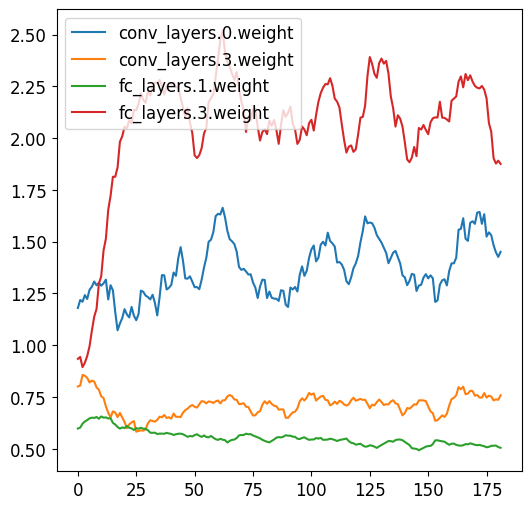

In [43]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(6,6))
sum_range=10

for _,pair in enumerate(net.named_parameters()):
    name,param=pair
    print(name,torch.numel(param))
    if 'bias' not in name:
        toplot=[x[_] for x in norms]
        plt.plot([np.sum(toplot[max(0, i-sum_range+1):i+1])/len(toplot[max(0, i-sum_range+1):i+1]) for i in range(sum_range,len(toplot))],label=name)
plt.legend()
plt.savefig('MNISTnorms_weight.pdf')
plt.show()

In [ ]:
0**0.2